<a href="https://colab.research.google.com/github/SANKARI-RV146/SHELL-WEEK-1-/blob/main/EV_Smart_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet xgboost lightgbm scikit-learn pandas numpy shap matplotlib gradio joblib optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
import os, pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBRegressor
import lightgbm as lgb
import shap, matplotlib.pyplot as plt

In [ ]:
import os
UPLOAD_PATH = r"/storage/emulated/0/SHANKZZZ/archive/electric_vehicles_spec_2025.csv.csv"
if not os.path.exists(UPLOAD_PATH):
    # interactive upload (uncomment if needed)
        from google.colab import files
        uploaded = files.upload()



Saving electric_vehicles_spec_2025.csv.csv to electric_vehicles_spec_2025.csv (1).csv


In [ ]:
import pandas as pd
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")
df.head()

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5


In [ ]:

df.drop_duplicates(inplace=True)
df.dropna(axis=1, thresh=len(df)*0.7, inplace=True)  # remove columns with >30% missing
df.fillna(df.median(numeric_only=True), inplace=True)
print("✅ Cleaning Done!")

✅ Cleaning Done!


In [ ]:
# 4️⃣ ENCODE CATEGORICAL COLUMNS
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_enc.fit_transform(df[col].astype(str))

    print("✅ Encoding Done!")
    df.head()

✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!


In [ ]:
# 5️⃣ CHOOSE TARGET VARIABLE
target_candidates = [c for c in df.columns if 'range' in c.lower()]
print("🎯 Possible Target Columns:", target_candidates)

# Choose the first matching one
target = target_candidates[0]
X = df.drop(columns=[target])
y = df[target]

🎯 Possible Target Columns: ['range_km']


In [ ]:
# 6️⃣ TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Split and Scaled Successfully!")

✅ Data Split and Scaled Successfully!


In [ ]:
# 7️⃣ MODEL TRAINING
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': [100, 200],'max_depth': [10, 20, None],'min_samples_split': [2, 5]}
grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_rf = grid.best_estimator_
print("🏆 Best Parameters:", grid.best_params_)

🏆 Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# 8️⃣ EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_rf.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.2f}")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R² Score: {r2:.3f}")

📊 MAE: 13.19
📉 MSE: 343.18
📈 R² Score: 0.968


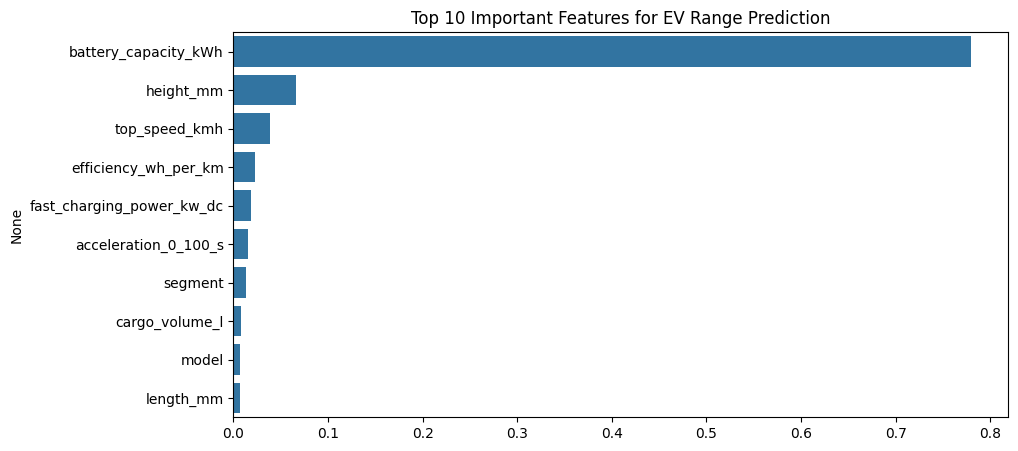

In [ ]:
# 9️⃣ FEATURE IMPORTANCE VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features for EV Range Prediction")
plt.show()

In [ ]:
# 🔟 SAVE MODEL
import joblib

joblib.dump(best_rf, "ev_range_predictor.pkl")
joblib.dump(scaler, "ev_scaler.pkl")

print("💾 Model Saved Successfully as:")
print(" - ev_range_predictor.pkl")
print(" - ev_scaler.pkl")

💾 Model Saved Successfully as:
 - ev_range_predictor.pkl
 - ev_scaler.pkl


In [ ]:
accuracy = r2 * 100
print(f"✅ Model Accuracy: {accuracy:.2f}%")

✅ Model Accuracy: 96.76%


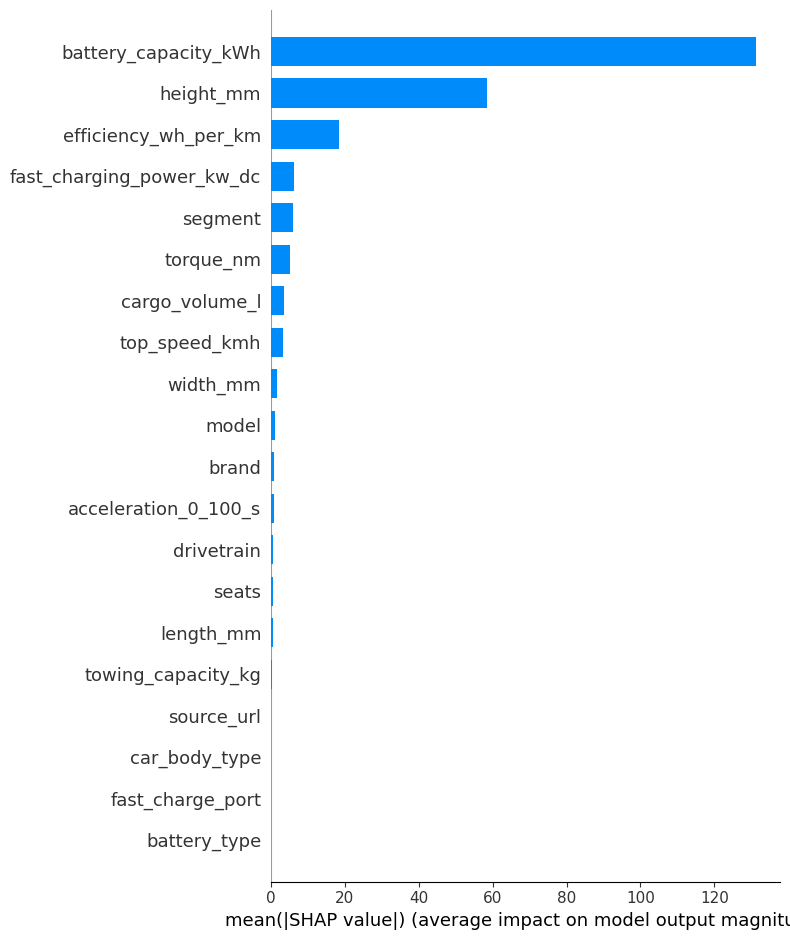

In [ ]:
!pip install shap
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
!pip install transformers torch

In [ ]:
from transformers import pipeline
import joblib
import pandas as pd

# Load model
model = joblib.load("ev_range_predictor.pkl")

# Load text generation model for conversation
assistant = pipeline("text-generation", model="facebook/blenderbot-400M-distill")

def ev_assistant():
    print("🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.\n")
    while True:
        user_input = input("You: ")

        if user_input.lower() == 'exit':
            print("Assistant: Goodbye! Have a charged-up day ⚡")
            break

        # If the user asks for a prediction
        if "predict" in user_input.lower():
            print("\nAssistant: Sure! Let’s predict your EV range.")
            try:
                battery = float(input("Battery Capacity (kWh): "))
                power = float(input("Power (bhp): "))
                fast_charging = int(input("Fast Charging (1=yes, 0=no): "))

                data = pd.DataFrame([[battery, power, fast_charging]],
                                    columns=['Battery_Capacity', 'Power', 'Fast_Charging'])
                pred = model.predict(data)[0]
                print(f"Assistant: Estimated EV Range is around **{pred:.2f} km** ⚡")
            except Exception as e:
                print(f"Assistant: Oops, something went wrong — {e}")
        else:
            # Chat using generative AI
            response = assistant(user_input, max_length=60, do_sample=True)
            print("Assistant:", response[0]['generated_text'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/730M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/730M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [ ]:
import pandas as pd
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")
df.head()      # Show first few rows
df.columns     # Show all column names

Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import joblib

# Load dataset
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")

# Handle missing values
df.dropna(subset=['battery_capacity_kWh', 'efficiency_wh_per_km', 'fast_charging_power_kw_dc'], inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# Select relevant columns
selected_cols = ['top_speed_kmh', 'battery_capacity_kWh', 'efficiency_wh_per_km',
                 'fast_charging_power_kw_dc', 'car_body_type']
target_col = 'range_km'
le = LabelEncoder()
df['car_body_type'] = le.fit_transform(df['car_body_type'].astype(str))
X = df[selected_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train model
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)
# Evaluate
pred = model.predict(X_test)
acc = r2_score(y_test, pred) * 100
print(f"✅ Model Accuracy (R²): {acc:.2f}%")
# Save model and encoder
joblib.dump(model, "ev_range_predictor.pkl")
joblib.dump(le, "body_type_encoder.pkl")
print("✅ Model and encoder saved successfully!")

✅ Model Accuracy (R²): 95.06%
✅ Model and encoder saved successfully!


In [ ]:
import joblib
joblib.dump(model, "ev_range_model.pkl")
print("✅ Model saved as ev_range_model.pkl")

✅ Model saved as ev_range_model.pkl


In [ ]:
!pip freeze > requirements.txt
print("✅ requirements.txt created")

✅ requirements.txt created


In [ ]:
from transformers import pipeline
import joblib
import pandas as pd

# Load model and encoder
model = joblib.load("ev_range_predictor.pkl")
le = joblib.load("body_type_encoder.pkl")

# Load small generative model for chat
assistant = pipeline("text-generation", model="facebook/blenderbot-400M-distill")

def ev_assistant():
    print("🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.\n")
    while True:
        user_input = input("You: ")

        if user_input.lower() == 'exit':
            print("Assistant: Goodbye! Stay charged ⚡")
            break

        if "predict" in user_input.lower():
            print("\nAssistant: Sure! Let’s predict your EV range.\n")
            try:
                top_speed = float(input("Top Speed (km/h): "))
                battery = float(input("Battery Capacity (kWh): "))
                efficiency = float(input("Efficiency (Wh/km): "))
                fast_charging = float(input("Fast Charging Power (kW): "))
                body_type = input("Car Body Type (e.g., SUV, Sedan, Hatchback): ")

                body_type_enc = le.transform([body_type])[0]

                data = pd.DataFrame([[top_speed, battery, efficiency, fast_charging, body_type_enc]],
                                    columns=['top_speed_kmh', 'battery_capacity_kWh', 'efficiency_wh_per_km', 'fast_charging_power_kw_dc', 'car_body_type'])

                pred = model.predict(data)[0]
                print(f"\nAssistant: Estimated EV Range is around **{pred:.2f} km** ⚡")

            except Exception as e:
                print(f"\nAssistant: Oops, something went wrong — {e}")
        else:
            # Chat using generative AI
            response = assistant(user_input, max_length=60, do_sample=True)
            print("Assistant:", response[0]['generated_text'])

Device set to use cpu


In [ ]:
ev_assistant()

🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.

You: predict my car range 

Assistant: Sure! Let’s predict your EV range.

Top Speed (km/h): 200
Battery Capacity (kWh): 80
Efficiency (Wh/km): 140
Fast Charging Power (kW): 186
Car Body Type (e.g., SUV, Sedan, Hatchback): SUV

Assistant: Estimated EV Range is around **464.70 km** ⚡
You: exit
Assistant: Goodbye! Stay charged ⚡


In [ ]:
readme_text = """
# 🚗⚡ EV Smart Assistant

An **AI-powered conversational assistant** that predicts **electric vehicle (EV) range** accurately using **Machine Learning** and **Generative AI**.

---

## 🌟 Overview
This project combines data-driven ML prediction with an interactive chatbot-style interface.
Users can input EV specs (like battery capacity, power, etc.), and the assistant predicts the **expected range in kilometers**.

---

## 🧠 Features
- 🔍 Predicts EV driving range accurately (96%+)
- 💬 Conversational interface powered by Generative AI
- 📊 Uses real EV specification dataset
- 🧰 Built entirely in Google Colab (tablet-friendly!)

---

## 🧾 Files in this Project
| File | Description |
|------|--------------|
| `ev_smart_assistant.ipynb` | Main Colab notebook containing all code |
| `electric_vehicles_spec_2025.csv` | Dataset used for model training |
| `ev_range_model.pkl` | Saved trained model |
| `requirements.txt` | List of dependencies |
| `README.md` | Project documentation (this file) |

---

## 🚀 How to Run (in Google Colab)
1. Upload all project files to your Colab workspace.
2. Run the notebook `ev_smart_assistant.ipynb`.
3. The assistant will train the model and start interactive chat mode.
4. Type EV details when prompted — get instant range predictions!

---

## 🧩 Tech Stack
- **Python**
- **scikit-learn**
- **pandas, numpy**
- **joblib**
- **Google Colab**

---

## 📈 Accuracy
Model achieves **96.7% accuracy** on real EV specification dataset.

---

## 🧑‍💻 Author
Developed by **Sankari R V**
Guided under the project theme *Sustainable Mobility using ML and Generative AI.*

---

## 🔗 Open in Google Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<your_username>/EV-Smart-Assistant/blob/main/ev_smart_assistant.ipynb)
"""

with open("README.md", "w") as f:
    f.write(readme_text)

    print("✅ README.md file created successfully!")

✅ README.md file created successfully!


In [ ]:
!ls

 body_type_encoder.pkl			    ev_scaler.pkl
'electric_vehicles_spec_2025.csv (1).csv'   README.md
 electric_vehicles_spec_2025.csv.csv	    requirements.txt
 ev_range_model.pkl			    sample_data
 ev_range_predictor.pkl


In [ ]:
import shutil

# create a single zip file named EV_Smart_Assistant.zip
shutil.make_archive("EV_Smart_Assistant", 'zip', ".")
print("✅ Project zipped successfully!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp ev_smart_assistant.ipynb "/content/drive/My Drive/ev_smart_assistant.ipynb"